<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    ML for Bioinformatics <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
<font color=3C99D size=5>
    Homework 2: Practical - Random Forest and XGboost <br>
<font color=696880 size=4>
    Bahar Oveisgharan (bahar.oveis.2000@gmail.com) <br>
    Ghazal Farahani (farahaniqazal@gmail.com)

____


### Full Name : Danial Ahangarani
### Student Number : 400211546
__

### Breasr Cancer
Most of us know someone who struggled with breast cancer, or at least heard about the struggles facing patients who are fighting against breast cancer.The most important part of a process of clinical decision-making in patients with cancers, in general, is the accurate estimation of prognosis and survival duration. Breast cancer patients with the same stage of the disease and the same clinical characteristics can have different treatment responses and overall survival.
In this practical assignment, you are going to train a Random Forest and XGBoost model on <code>breast_cancer.csv</code> dataset.

Import all the libraries you may need here

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, mean_squared_error, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold
from scipy.stats import uniform, randint
import xgboost as xgb
import matplotlib.pyplot as plt
#import graphviz
from xgboost import plot_tree

#### Loading the Data

In [4]:
df = pd.read_csv('breast_cancer.csv')
df = df.drop(columns=['Unnamed: 0'])

In [5]:
df.dropna(inplace=True)
df

,age_at_diagnosis,type_of_breast_surgery,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,er_status,neoplasm_histologic_grade,...,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,oncotree_code,pr_status,radio_therapy,3-gene_classifier_subtype,tumor_size,tumor_stage,overall_survival
1,43.19,BREAST CONSERVING,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,Positive,3.0,...,0.0,2.0,4.020,IDC,Positive,1,ER+/HER2- High Prolif,10.0,1.000000,1
4,76.97,MASTECTOMY,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,Positive,3.0,...,8.0,2.0,6.080,MDLC,Positive,1,ER+/HER2- High Prolif,40.0,2.000000,0
5,78.77,MASTECTOMY,Breast Invasive Ductal Carcinoma,Moderate,0,LumB,1.0,Positve,Positive,3.0,...,0.0,4.0,4.062,IDC,Positive,1,ER+/HER2- High Prolif,31.0,4.000000,0
8,86.41,BREAST CONSERVING,Breast Invasive Ductal Carcinoma,Moderate,0,LumB,1.0,Positve,Positive,3.0,...,1.0,4.0,5.032,IDC,Negative,1,ER+/HER2- High Prolif,16.0,2.000000,0
9,84.22,MASTECTOMY,Breast Invasive Lobular Carcinoma,High,0,Her2,1.0,Negative,Positive,2.0,...,0.0,5.0,3.056,ILC,Negative,0,ER+/HER2- High Prolif,28.0,2.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1884,67.89,MASTECTOMY,Breast Invasive Ductal Carcinoma,High,0,LumA,4.0,Positve,Positive,2.0,...,1.0,3.0,4.030,IDC,Positive,0,ER+/HER2- Low Prolif,15.0,1.750535,0
1886,63.50,MASTECTOMY,Breast Invasive Ductal Carcinoma,High,0,LumA,4.0,Positve,Positive,2.0,...,6.0,6.0,5.080,IDC,Positive,0,ER+/HER2- High Prolif,40.0,1.750535,1
1889,61.23,MASTECTOMY,Breast Invasive Ductal Carcinoma,High,0,LumA,4.0,Positve,Positive,3.0,...,1.0,5.0,5.030,IDC,Negative,0,ER+/HER2- Low Prolif,15.0,1.750535,0
1891,66.48,MASTECTOMY,Breast Invasive Ductal Carcinoma,High,0,LumB,4.0,Positve,Positive,3.0,...,3.0,2.0,5.050,IDC,Negative,0,ER+/HER2- High Prolif,25.0,1.750535,0


### Data Exploration
#### Let's start off by exploring the files we just imported. it's not necessary to do any visualization just a statistical summary of the data would be enough. split your data to train and test.

In [6]:
summary = df.describe()
summary

,age_at_diagnosis,chemotherapy,cohort,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,radio_therapy,tumor_size,tumor_stage,overall_survival
count,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000,1520.000000
mean,61.198849,0.203289,2.625658,2.416093,0.617105,1.945395,5.735741,4.033242,0.594737,26.350589,1.752593,0.432895
std,13.032609,0.402579,1.225148,0.635871,0.486253,3.871068,4.135842,1.135955,0.491104,15.311120,0.550407,0.495639
min,21.930000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.020000,0.000000,1.000000,0.000000,0.000000
25%,51.410000,0.000000,1.000000,2.000000,0.000000,0.000000,3.000000,3.046000,0.000000,17.725000,1.000000,0.000000
50%,61.960000,0.000000,3.000000,2.415939,1.000000,0.000000,5.000000,4.042000,1.000000,23.000000,2.000000,0.000000
75%,70.707500,0.000000,3.000000,3.000000,1.000000,2.000000,7.000000,5.042000,1.000000,30.000000,2.000000,1.000000
max,96.290000,1.000000,5.000000,3.000000,1.000000,41.000000,80.000000,6.360000,1.000000,182.000000,4.000000,1.000000


### Data Preparation
#### Creating two custom transformers to put on our pipeline:
* To split the data into categorical and numerical features and
* To preprocess the categorical features. 
* Create the X feature matrix and the y target vector.
* split the data.

In [10]:
class NumericalSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.feature_names]


class CategoricalSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.feature_names]

    
# Define X and y
X = df.drop(columns=["overall_survival"])
y = df["overall_survival"]

# Define the column transformer to preprocess numerical and categorical features separately
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing pipeline for categorical features
categorical_preprocessor = Pipeline([
    ("cat_selector", CategoricalSelector(feature_names=categorical_features)),
    ("one_hot", OneHotEncoder(handle_unknown='ignore'))
])

# Define preprocessing pipeline for numerical features
numerical_preprocessor = Pipeline([
    ("num_selector", NumericalSelector(feature_names=numerical_features)),
    ("scaler", StandardScaler())
])

# Define preprocessing pipeline for all features
preprocessor = ColumnTransformer([
    ("num", numerical_preprocessor, numerical_features),
    ("cat", categorical_preprocessor, categorical_features)
], remainder="passthrough")


# Fit the preprocessor on the training data
preprocessor.fit(X_train)

# Get one-hot encoded feature names
one_hot_encoded_feature_names = preprocessor.named_transformers_['cat'].named_steps['one_hot'].get_feature_names_out(categorical_features)


# Get column names for preprocessed data
column_names = numerical_features.copy()
column_names.extend(one_hot_encoded_feature_names)
if 'remainder' in preprocessor.named_transformers_:
    column_names += preprocessor.named_transformers_['remainder'][1]



# Transform training and test data using preprocessing pipeline
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Convert preprocessed arrays back to dataframes
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=column_names)
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=column_names)

# Implementing two different models

## Random Forest

### train the model

In [11]:
# Initialize a Random Forest classifier with default hyperparameters
rfc = RandomForestClassifier()

# Train the model on the training data
rfc.fit(X_train_preprocessed_df, y_train)

RandomForestClassifier()

### Model assessment
#### Print Train Accuracy, Test Accuracy and classification Report.


In [12]:
# Use the trained model to predict labels for the test data
y_pred = rfc.predict(X_test_preprocessed_df)

print('Classification Report:')
# Print the classification report for the model's performance on the test set
print(classification_report(y_test, y_pred))

# Calculate and print the training and testing accuracies
train_acc = rfc.score(X_train_preprocessed_df, y_train)
test_acc = rfc.score(X_test_preprocessed_df, y_test)
print("Train accuracy:", train_acc)
print("Test accuracy:", test_acc)

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.76      0.75       184
           1       0.61      0.57      0.59       120

    accuracy                           0.69       304
   macro avg       0.67      0.67      0.67       304
weighted avg       0.68      0.69      0.69       304

Train accuracy: 1.0
Test accuracy: 0.6875


### Hyperparameter tuning :
#### Randomized Search Cross Validation and Grid Search Cross Validation
report best hyperparameters in each part.

In [13]:
# Define the hyperparameter grid for Randomized Search CV
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': [3, 5, 10, None],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

# Define the hyperparameter grid for Grid Search CV
param_grid = {
    'n_estimators': [500, 800, 1000],
    'max_depth': [6, 8, 10],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'bootstrap': [True],
    'criterion': ['gini', 'entropy']
}

# Create a random forest classifier instance
rfc = RandomForestClassifier()

# Perform Randomized Search CV
rs_cv = RandomizedSearchCV(
    estimator=rfc,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    n_jobs=-1,
    random_state=42
)
rs_cv.fit(X_train_preprocessed_df, y_train)

# Report the best hyperparameters from Randomized Search CV
print("Best hyperparameters from Randomized Search CV:")
print(rs_cv.best_params_)
print()

# Fit the model using the best hyperparameters from Randomized Search CV
rfc.set_params(**rs_cv.best_params_)
rfc.fit(X_train_preprocessed_df, y_train)

# Report the test score using the best hyperparameters from Randomized Search CV
test_score = rfc.score(X_test_preprocessed_df, y_test)
print(f"Test score using best hyperparameters from Randomized Search CV: {test_score:.4f}")
print()

# Perform Grid Search CV
gs_cv = GridSearchCV(
    estimator=rfc,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
)
gs_cv.fit(X_train_preprocessed_df, y_train)

# Report the best hyperparameters from Grid Search CV
print("Best hyperparameters from Grid Search CV:")
print(gs_cv.best_params_)
print()

# Fit the model using the best hyperparameters from Grid Search CV
rfc.set_params(**gs_cv.best_params_)
rfc.fit(X_train_preprocessed_df, y_train)

# Report the test score using the best hyperparameters from Grid Search CV
test_score = rfc.score(X_test_preprocessed_df, y_test)
print(f"Test score using best hyperparameters from Grid Search CV: {test_score:.4f}")


Best hyperparameters from Randomized Search CV:
{'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 971}

Test score using best hyperparameters from Randomized Search CV: 0.6908

Best hyperparameters from Grid Search CV:
{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 800}

Test score using best hyperparameters from Grid Search CV: 0.6908


### Find important features with Random Forest model 
#### Visualize feature scores of the features

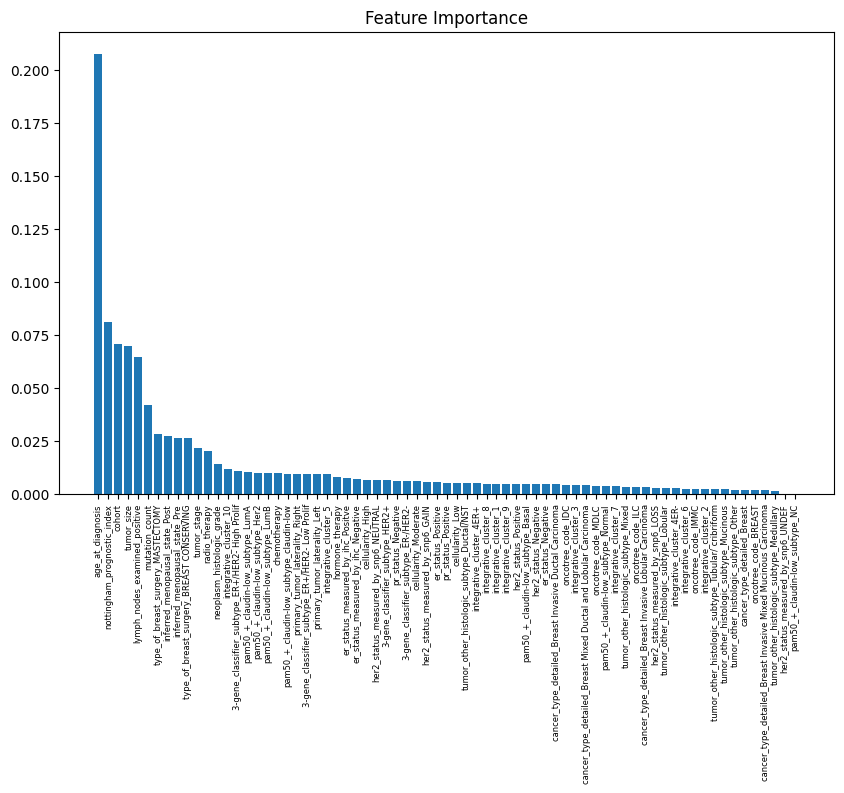

In [14]:
# Get the feature importances
importances = rfc.feature_importances_

# Sort the features by importance
indices = np.argsort(importances)[::-1]

# Visualize the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(X_train_preprocessed_df.shape[1]), importances[indices])
plt.xticks(range(X_train_preprocessed_df.shape[1]), X_train_preprocessed_df.columns[indices], rotation=90, fontsize=6)
plt.show()


### * Improve Model (Bonus)
In this bonus part, you can add your ideas for improving your model's performance. implement it and compare the results.

## XGBoost
### Train the model

In [17]:
# Train an XGBoost classifier
model = xgb.XGBClassifier(objective='binary:logistic')
eval_set = [(X_train_preprocessed_df, y_train), (X_test_preprocessed_df, y_test)]
model.fit(X_train_preprocessed_df, y_train, eval_metric=['error'], eval_set=eval_set, verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### Model assessment
#### Print Train Accuracy, Test Accuracy and classification Report.



In [18]:
# Make predictions on the train and test sets
y_train_pred = model.predict(X_train_preprocessed_df)
y_test_pred = model.predict(X_test_preprocessed_df)

# Calculate the train and test accuracies
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

# Print the train and test accuracies
print('Train Accuracy:', train_acc)
print('Test Accuracy:', test_acc)

# Print the classification report
report = classification_report(y_test, y_test_pred)
print('Classification Report:\n', report)



Train Accuracy: 1.0
Test Accuracy: 0.7039473684210527
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.76      0.76       184
           1       0.62      0.62      0.62       120

    accuracy                           0.70       304
   macro avg       0.69      0.69      0.69       304
weighted avg       0.70      0.70      0.70       304



### Plot the results

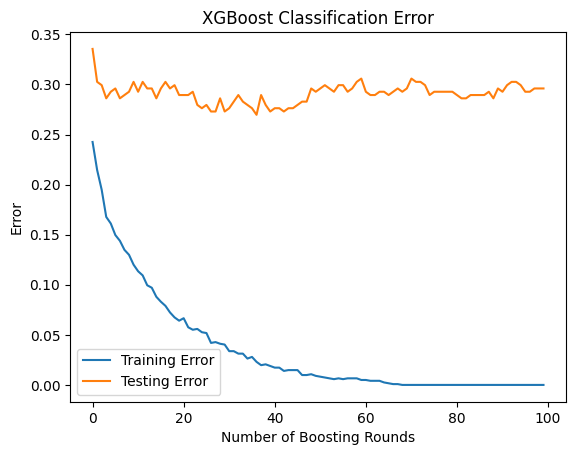

In [19]:
# Extract the training and testing error values from the trained model
results = model.evals_result()
train_errors = results['validation_0']['error']
test_errors = results['validation_1']['error']

# Plot the training and testing error curves
plt.plot(train_errors, label='Training Error')
plt.plot(test_errors, label='Testing Error')
plt.title('XGBoost Classification Error')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Error')
plt.legend()
plt.show()

### Hyperparameter tuning: Grid Search and Cross validation
* create a default XGBoost classifier.
* create the Kfold object. You can use tratifiedKFold from sklearn.model_selection.
* create the grid search object. You can use RandomizedSearchCV from sklearn.model_selection.
* fit grid search.

In [22]:
# Create the default XGBoost classifier
model = xgb.XGBClassifier(objective='binary:logistic')

# Set up the hyperparameter grid
params = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'gamma': uniform(0, 1),
}

# Create the Kfold object
kf = KFold(n_splits=5, shuffle=True)

# Create the RandomizedSearchCV object
search = RandomizedSearchCV(model, params, cv=kf, scoring='accuracy', n_iter=10, n_jobs=-1)

# Fit the grid search
search.fit(X_train_preprocessed_df, y_train)

# Print the best hyperparameters and score
print('Best Parameters:', search.best_params_)
print('Best Score:', search.best_score_)


Best Parameters: {'gamma': 0.7341312946623799, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
Best Score: 0.7055994063280038


### Assessing model performance using the best model from grid search
#### Print Train Accuracy, Test Accuracy and Classification Report.

In [20]:
# Get the best model from the grid search
best_model = search.best_estimator_

# Make predictions on the train and test sets using the best model
y_train_pred = best_model.predict(X_train_preprocessed_df)
y_test_pred = best_model.predict(X_test_preprocessed_df)

# Calculate the train and test accuracies
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

# Print the train and test accuracies
print('Train Accuracy:', train_acc)
print('Test Accuracy:', test_acc)

# Print the classification report
report = classification_report(y_test, y_test_pred)
print('Classification Report:\n', report)

Train Accuracy: 0.9161184210526315
Test Accuracy: 0.7236842105263158
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.78      0.77       184
           1       0.65      0.64      0.65       120

    accuracy                           0.72       304
   macro avg       0.71      0.71      0.71       304
weighted avg       0.72      0.72      0.72       304



### Create the feature importances plot, plot a decision tree from the booster.

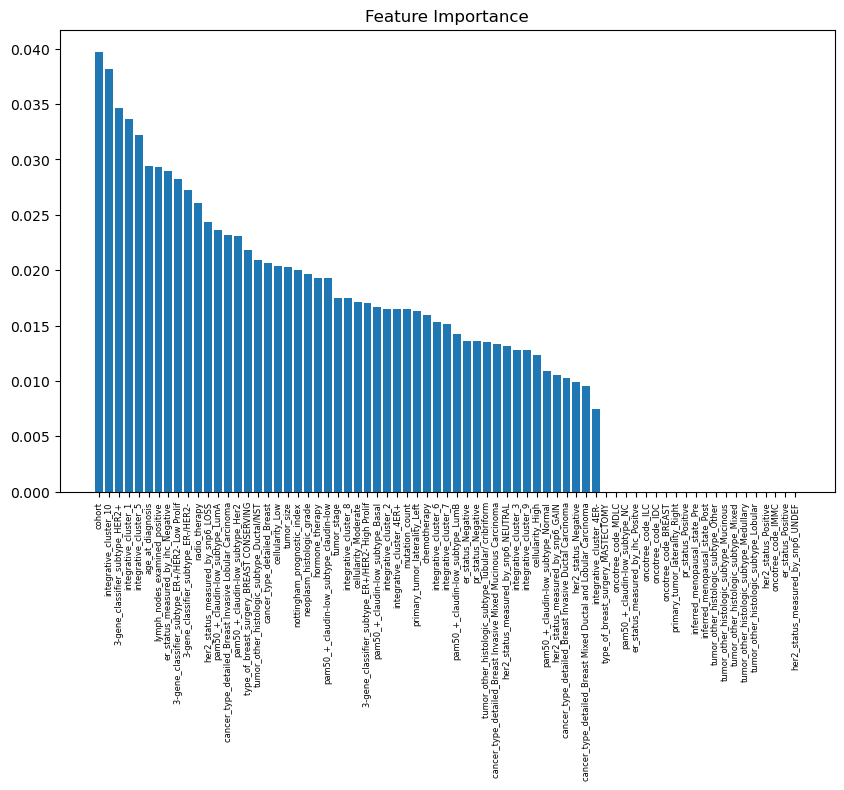

In [22]:
# Train an XGBoost classifier
model = xgb.XGBClassifier(objective='binary:logistic')
model.fit(X_train_preprocessed_df, y_train)

# Get the feature importances
importances = model.feature_importances_

# Sort the features by importance
indices = np.argsort(importances)[::-1]

# Visualize the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(X_train_preprocessed_df.shape[1]), importances[indices])
plt.xticks(range(X_train_preprocessed_df.shape[1]), X_train_preprocessed_df.columns[indices], rotation=90, fontsize=6)
plt.show()

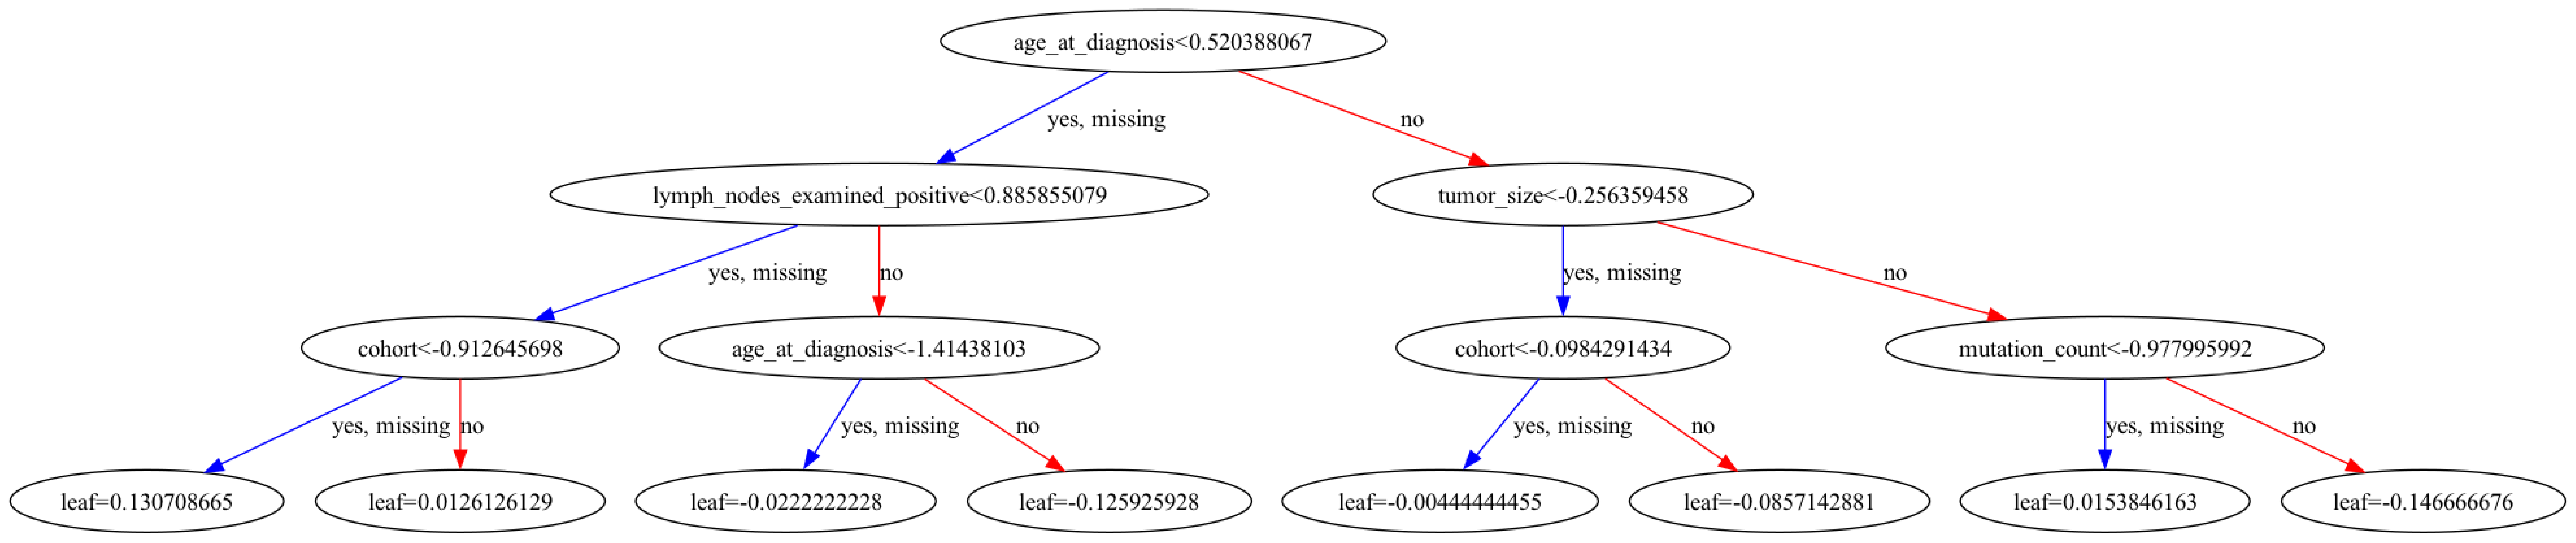

In [44]:
# Define the hyperparameters for the XGBoost model
params = {
    'max_depth': 3,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'objective': 'binary:logistic',
    'gamma': 0.0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.0,
    'reg_lambda': 1.0,
    'random_state': 42
}

# Create an instance of the XGBClassifier with the specified hyperparameters
model = xgb.XGBClassifier(**params)
model.fit(X_train_preprocessed_df, y_train)

# Plot one of the trees in the booster (e.g., the first tree)
fig, ax = plt.subplots(figsize=(100, 100))
xgb.plot_tree(model, num_trees=0, ax=ax)
plt.show()

The tree was too small with the current search parameters, so I plotted it with different parameters.

### * Improve Model (Bonus)
In this bonus part, you can add your ideas for improving your model's performance. You can implement your model and compare the results.

## Comparison between XGBoost and Random Forest Classifier

Compare the results from these two models. How Would you rate each method in terms of its performance? What's the difference between these models? explain.

There may not be a significant difference between these models; however,

The key idea behind Random Forest is to reduce overfitting by combining many decision trees, each trained on different randomly sampled subsets of the training data.

On the other hand, it has been shown(XGBoost) to be more powerful and efficient than Random Forest in some cases due to its ability to learn complex interactions between features and handle missing values more effectively.

In terms of differences between XGBoost and Random Forest, one major difference is the way they handle missing data. XGBoost has an inbuilt capability to handle missing data whereas Random Forest does not. Additionally, XGBoost often outperforms Random Forest in terms of accuracy.

Perhaps XGBoost performs better on this dataset due to certain factors.